# Expirements - Collaborative Filtering (Ridge ALS, Implicit ALS, NCF)

The base model will be a simple collaborative filtering system based on the interractions matrix

## Table of content:

- Baseline Model - User based Nearest Neighbor
- Ridge ALS (Alternative Least Square) - Matrix Factorization
- Implicit ALS (Alternative Least Square) - Matrix Factorization
- NCF (Neural Collaborative Filtering)

Learns latent representations from the interaction matrix:

- User Features: Not Used
- Item Features: Not Used
- Interaction Features: Feedbacks (watch ratio)
- Temporal Features: Not Used

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from typing import Dict, List, Any, Tuple
from sklearn.metrics.pairwise import cosine_similarity
import random
from collections import defaultdict
import math
import sys
import os

sys.path.insert(1, os.path.abspath("../.."))

from src.models.collaborative_baseline import CollaborativeFiltering
from src.models.collaborative_ridge_als import CollaborativeFilteringALS
from src.models.collaborative_implicit import CollaborativeFilteringImplicitALS
from src.models.collaborative_ncf import CollaborativeFilteringNCF

from src.pipelines.collaborative_pipeline import CollaborativePipeline

from src.metrics.novelty import novelty
from src.metrics.bench import bench_model
from src.utils.random import set_seed
from src.utils.ground_truth import build_ground_truth_at_least_once, build_ground_truth_at_least_once_entirely, build_ground_truth_mean

set_seed(45)

plt.rcParams["figure.figsize"] = (20, 13)
colors = plt.get_cmap('tab10').colors
plt.rc('axes', prop_cycle=cycler('color', colors))

%matplotlib inline
%config InlineBackend.figure_format = "retina"

2025-05-16 15:39:04.365091: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 15:39:04.375575: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 15:39:04.407434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747409944.460172  282892 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747409944.476068  282892 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747409944.520696  282892 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Preprocess

In [2]:
save_dir = "../../save"
os.makedirs(save_dir, exist_ok=True)

data_path = os.path.join(save_dir, "data_collaborative_preprocessed.csv")
test_data_path = os.path.join(save_dir, "test_data_collaborative_preprocessed.csv")

if os.path.exists(data_path) and os.path.exists(test_data_path):
    print("Loading preprocessed data...")
    data_preprocessed = pd.read_csv(data_path)
    test_data_preprocessed = pd.read_csv(test_data_path)
else:
    print("Preprocessing data...")
    interaction_train = pd.read_csv("../data_final_project/KuaiRec 2.0/data/big_matrix.csv")#
    interaction_test = pd.read_csv("../data_final_project/KuaiRec 2.0/data/small_matrix.csv")
    pipeline = CollaborativePipeline()
    data_preprocessed = pipeline.transform(interaction_train)
    test_data_preprocessed = pipeline.transform(interaction_test)

    print("Saving preprocessed data...")
    data_preprocessed.to_csv(data_path, index=False)
    test_data_preprocessed.to_csv(test_data_path, index=False)

Loading preprocessed data...


In [5]:
test_data_preprocessed

video_id,103,109,120,122,128,130,131,133,136,137,...,10430,10436,10457,10462,10500,10506,10519,10552,10589,10595
user_id,,,,,,,,,,,,,,,,,,,,,
14,0.429126,1.482039,0.728738,0.477810,0.439333,1.150245,1.816317,0.781122,1.554396,2.307486,...,0.348932,0.965220,1.787169,1.816010,0.150323,1.535256,2.757278,0.143556,1.273362,1.719201
19,0.624466,1.070684,1.006064,0.759092,0.882691,0.639313,0.670019,1.407319,0.874814,0.722665,...,0.642896,0.633833,0.586222,1.178295,NaN,0.977297,1.266322,0.265038,0.928168,1.107873
21,1.415049,1.028840,1.809125,0.688823,0.588365,0.619549,0.818749,1.944596,1.015039,0.575723,...,0.896847,0.918930,0.602573,0.995887,1.173871,0.957399,1.148837,0.216699,1.210398,1.713792
23,0.169223,2.549891,0.247487,0.438669,0.114338,0.828292,0.038440,2.455882,1.128438,1.021400,...,0.577134,0.335534,5.304503,0.610346,0.185161,4.725427,0.338674,0.430445,2.225363,NaN
24,0.345049,0.449337,0.802936,0.797411,1.875599,0.783867,2.104939,6.418434,0.228018,3.892566,...,0.884743,0.578658,0.300125,2.151558,2.311935,1.848424,0.388630,0.103633,0.547944,0.093900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7142,0.575631,0.960989,0.950854,0.611157,0.569484,0.944994,0.481794,1.020178,0.805988,0.514642,...,0.727006,0.794809,0.843906,1.491536,1.525323,1.261752,1.630146,0.300578,1.047888,1.419171
7147,1.112427,0.380971,1.419818,0.617423,1.067951,1.020166,0.925878,1.656635,0.907465,0.722232,...,0.541901,0.813574,1.014475,1.575067,1.614839,1.191774,1.935745,0.261799,0.974836,1.364633
7153,1.338544,0.414703,0.664433,0.339429,1.038049,0.225616,0.425432,2.330027,2.045522,0.604141,...,0.568422,0.887281,0.287259,4.364816,0.898387,0.944044,1.031352,0.309217,0.723977,0.425931


In [6]:
data_preprocessed

video_id,0,1,2,3,4,5,6,7,8,9,...,10718,10719,10720,10721,10722,10723,10724,10725,10726,10727
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.037248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.452116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Ground Truth

In [3]:
train_ground_truth = build_ground_truth_at_least_once(data_preprocessed)
test_ground_truth = build_ground_truth_at_least_once(test_data_preprocessed)

### Item Popularity

In [ ]:
item_popularity = compute_popularity(data_preprocessed, test_data_preprocessed)

## User based Nearest Neighbor - Base Model

The base model will simply get all interactions from all users (that has watched the video) and recommend the video that their similar user watched

User's similarity will be computed from interaction matrix and be used to weighten recommended videos

<div style="text-align: center;">
  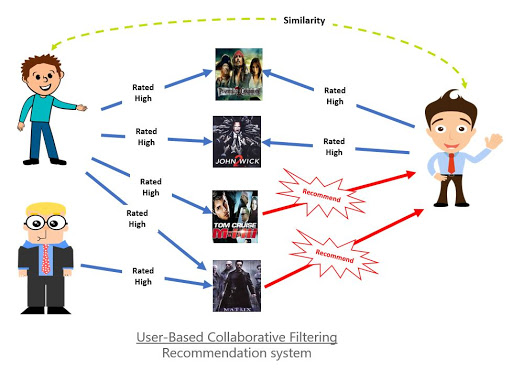
</div>

### Model

In [4]:
baseline_cf_model = CollaborativeFiltering()
baseline_cf_model.fit(data_preprocessed)
recommendations = baseline_cf_model.predict(user_id=14, top_n=10)
print(recommendations)

fit took 11.1497 seconds
predict took 12.4637 seconds
['3400', '10435', '1709', '7356', '2123', '314', '5434', '7812', '7383', '9130']


In [5]:
baseline_cf_model.save("../../save/collaborative_baseline/default.pkl")

### Evaluation

In [6]:
baseline_cf_model = CollaborativeFiltering().load("../../save/collaborative_baseline/default.pkl")

In [7]:
K = 100
N_USERS = 10

#### Sampling recommendations and ground truth

In [8]:
# testing on some users
for user in [14, 19, 21, 23]:
    recommendations = baseline_cf_model.predict(user_id=user, top_n=K)
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(recommendations)))} / {K} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(recommendations)))} / {K} test recommendations in ground truth")

predict took 14.1175 seconds
user 14: 100 / 100 train recommendations in ground truth
user 14: 48 / 100 test recommendations in ground truth
predict took 14.2508 seconds
user 19: 100 / 100 train recommendations in ground truth
user 19: 43 / 100 test recommendations in ground truth
predict took 14.0995 seconds
user 21: 99 / 100 train recommendations in ground truth
user 21: 44 / 100 test recommendations in ground truth
predict took 14.6398 seconds
user 23: 100 / 100 train recommendations in ground truth
user 23: 59 / 100 test recommendations in ground truth


In [9]:
train_sample_user_ids = random.sample(list(data_preprocessed.index), min(N_USERS, len(data_preprocessed)))
train_sample_recommendations = {}
print(f"Selected users: {train_sample_user_ids}")
for user_id in train_sample_user_ids:
    train_sample_recommendations[user_id] = baseline_cf_model.predict(user_id=user_id, top_n=K)

train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = random.sample(list(test_data_preprocessed.index), min(N_USERS, len(test_data_preprocessed)))
test_sample_recommendations = {}
print(f"Selected users: {test_sample_user_ids}")
for user_id in test_sample_user_ids:
    test_sample_recommendations[user_id] = baseline_cf_model.predict(user_id=user_id, top_n=K)

test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

Selected users: [2227, 3421, 3997, 2110, 670, 2483, 2774, 176, 592, 3967]
predict took 14.0154 seconds
predict took 14.6065 seconds
predict took 14.6690 seconds
predict took 13.9201 seconds
predict took 14.7288 seconds
predict took 13.5907 seconds
predict took 13.3214 seconds
predict took 14.6356 seconds
predict took 14.4400 seconds
predict took 13.9741 seconds
Selected users: [22, 235, 581, 241, 637, 1329, 73, 1279, 136, 276]
predict took 13.8074 seconds
predict took 13.7229 seconds
predict took 13.8666 seconds
predict took 13.8105 seconds
predict took 13.7705 seconds
predict took 13.9319 seconds
predict took 13.9837 seconds
predict took 13.8561 seconds
predict took 13.9309 seconds
predict took 13.9167 seconds


#### Bench Model (NDCG@K, MAP@K, MAR@K, F1@K)

In [ ]:
print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K)

#### Novelty

In [22]:
novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")

NameError: name 'item_popularity' is not defined

### Conclusion

The baseline model shows strong performance on the training set, with nearly perfect metrics: NDCG@100 and MAP@100 both at 0.99. However, we can clearly see an overfitting effect when evaluating on the testing set.

The large drop in NDCG and MAP on the test set suggests that the model memorized the training data rather than learning generalizable patterns.

The model is also very slow, that's why I am computing benchmark on only 40 randomly selected user.

To improve this model, we could try techniques like regularization or using more powerful models such as MF.

| Type    | k   | Users | NDCG@100   | MAP@100   | MAR@100   | F1@100    |
|----------|-----|--------|------------|-----------|-----------|-----------|
| Training | 100 | 40     | 0.990000   | 0.990000  | 0.009000  | 0.018000  |
| Testing  | 100 | 40     | 0.384388   | 0.450500  | 0.013595  | 0.026393  |

---


## Matrix Factorization with Ridge ALS - Collaborative Filtering

This is the Matrix Factorization approach using ALS algorithm and Ridge regularization - See [paper](https://ieeexplore.ieee.org/document/7888956/)

This collaborative filtering model uses ALS algorithm.

**Assumption**: we approximate the user-item matrix using matrix factorization into two embdeddings: $\hat{Y} \approx U^TV$

**Predictions**:

$$ Y = (U^T V)$$
- $U$ is a learned matrix representing user embeddings.
- $V$ is a learned matrix of representing item embeddings.

**Cost Function**:

$$ E_{RALS}(U, V) = || R \cdot (\hat{Y} - U^TV) ||^2 + \lambda_1 || U ||^2 + \lambda_2 || V ||^2 $$

$R$ is a binary matrix to filter out missing values

**Learning**:

From the paper, the derivative of the cost function on $U$ and $V$ is given by:

<center><img src="images/ALS_loss_derivative.png" style="width: 30%; height: auto;" /></center>

These are convex problem, global minima is found by zeroing the above equation. Thus we can find that at each step:

$$ V = (UU^T + \lambda_1 I)^{-1} U (R * \hat{Y}) $$

$$ U = (VV^T + \lambda_2 I)^{-1} V (R * \hat{Y})^T $$

$\lambda_n$ are hyperparameters, by default 1

custom implementation at `src/models/collaborative_ridge_als.py`

### Models & Hyperparam Tuning

Starting training with params: {'num_feature': 50, 'lambda': 1, 'scale': 0.1, 'normalization': False, 'reg': True}
Iteration 0: MSE loss = 2.8843
Mean absolute error (watch ratio predicted gap) 0.6922
Iteration 5: MSE loss = 2.5020
Mean absolute error (watch ratio predicted gap) 0.6163
Iteration 10: MSE loss = 2.4997


2025-05-14 20:44:28,828 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.1_features50_lambda1_regTrue_normFalse


Mean absolute error (watch ratio predicted gap) 0.6141
Early stopping at iteration 10, recent losses: [2.500846601529754, 2.500267775101355, 2.4999707377282783, 2.499814547495252, 2.4997284666545285]
fit took 78.9374 seconds
Starting training with params: {'num_feature': 50, 'lambda': 1, 'scale': 0.1, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.4892
Mean absolute error (watch ratio predicted gap) 1.2073
Iteration 5: MSE loss = 3.2097
Mean absolute error (watch ratio predicted gap) 1.1923


2025-05-14 20:45:49,683 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.1_features50_lambda1_regTrue_normTrue


Early stopping at iteration 9, recent losses: [3.2096955431749628, 3.209254702270044, 3.2091805227298082, 3.2092446972222857, 3.209352528165707]
fit took 80.6448 seconds
Starting training with params: {'num_feature': 50, 'lambda': 1, 'scale': 0.2, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.4811
Mean absolute error (watch ratio predicted gap) 1.2065
Iteration 5: MSE loss = 3.2125
Mean absolute error (watch ratio predicted gap) 1.1926


2025-05-14 20:47:06,801 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.2_features50_lambda1_regTrue_normTrue


Early stopping at iteration 9, recent losses: [3.212476814495283, 3.2116678093287154, 3.2113049262873474, 3.2111530940265323, 3.2111040512467417]
fit took 76.9640 seconds
Starting training with params: {'num_feature': 100, 'lambda': 1, 'scale': 0.3, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.3226
Mean absolute error (watch ratio predicted gap) 1.2013
Iteration 5: MSE loss = 2.9432
Mean absolute error (watch ratio predicted gap) 1.1798
Iteration 10: MSE loss = 2.9379
Mean absolute error (watch ratio predicted gap) 1.1784


2025-05-14 20:49:06,028 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.3_features100_lambda1_regTrue_normTrue


Early stopping at iteration 11, recent losses: [2.9399940126834556, 2.9390838033149693, 2.938406215888693, 2.9378918038818456, 2.9374965368270947]
fit took 119.0360 seconds
Starting training with params: {'num_feature': 200, 'lambda': 1, 'scale': 0.3, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.0203
Mean absolute error (watch ratio predicted gap) 1.1846
Iteration 5: MSE loss = 2.5545
Mean absolute error (watch ratio predicted gap) 1.1557
Iteration 10: MSE loss = 2.5470
Mean absolute error (watch ratio predicted gap) 1.1541


2025-05-14 20:52:05,813 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.3_features200_lambda1_regTrue_normTrue


Early stopping at iteration 12, recent losses: [2.54877414818247, 2.547792265702546, 2.547020693929389, 2.546396925084527, 2.5458803438906754]
fit took 179.6131 seconds
Starting training with params: {'num_feature': 30, 'lambda': 0.1, 'scale': 0.2, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.5825
Mean absolute error (watch ratio predicted gap) 1.2134
Iteration 5: MSE loss = 3.3497
Mean absolute error (watch ratio predicted gap) 1.1981


2025-05-14 20:53:19,927 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.2_features30_lambda0.1_regTrue_normTrue


Early stopping at iteration 9, recent losses: [3.349707333967979, 3.349238276731814, 3.349179531654415, 3.349302796240319, 3.349490168203878]
fit took 73.9705 seconds
Starting training with params: {'num_feature': 30, 'lambda': 0.0, 'scale': 0.2, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.5673
Mean absolute error (watch ratio predicted gap) 1.2091
Iteration 5: MSE loss = 3.3505
Mean absolute error (watch ratio predicted gap) 1.1980


2025-05-14 20:54:40,060 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.2_features30_lambda0.0_regTrue_normTrue


Early stopping at iteration 9, recent losses: [3.3505345987777897, 3.3500519274801044, 3.349840565846987, 3.3497697211729696, 3.3497829634486638]
fit took 78.9173 seconds
Starting training with params: {'num_feature': 50, 'lambda': 0.0, 'scale': 0.5, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 3.4831
Mean absolute error (watch ratio predicted gap) 1.2096
Iteration 5: MSE loss = 3.2075
Mean absolute error (watch ratio predicted gap) 1.1918


2025-05-14 20:55:56,521 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.5_features50_lambda0.0_regTrue_normTrue


Early stopping at iteration 9, recent losses: [3.207469851235055, 3.2073185138833367, 3.2075154973720204, 3.2078113585348444, 3.208107600754665]
fit took 76.2769 seconds
Starting training with params: {'num_feature': 500, 'lambda': 0.0, 'scale': 0.5, 'normalization': True, 'reg': True}
Iteration 0: MSE loss = 2.2983
Mean absolute error (watch ratio predicted gap) 1.1383
Iteration 5: MSE loss = 1.8860
Mean absolute error (watch ratio predicted gap) 1.0969


2025-05-14 21:00:06,499 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_als/scale0.5_features500_lambda0.0_regTrue_normTrue


Early stopping at iteration 9, recent losses: [1.885992319034139, 1.8850069057619692, 1.8844485950593546, 1.8841102885462349, 1.8838947273325177]
fit took 249.7737 seconds


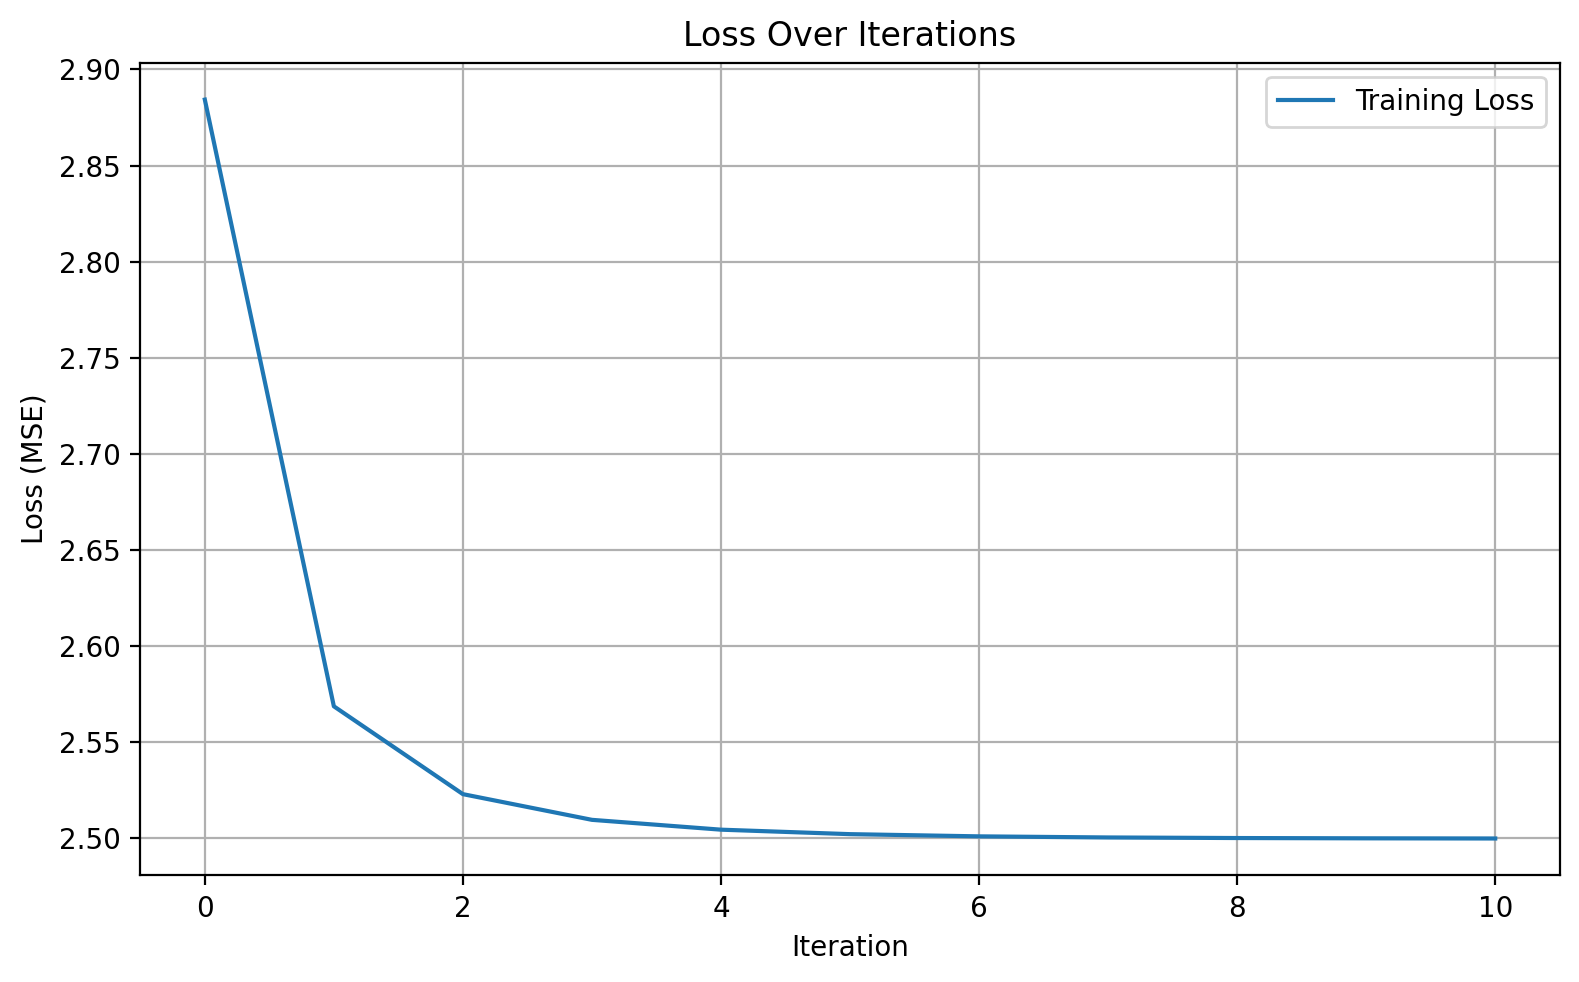

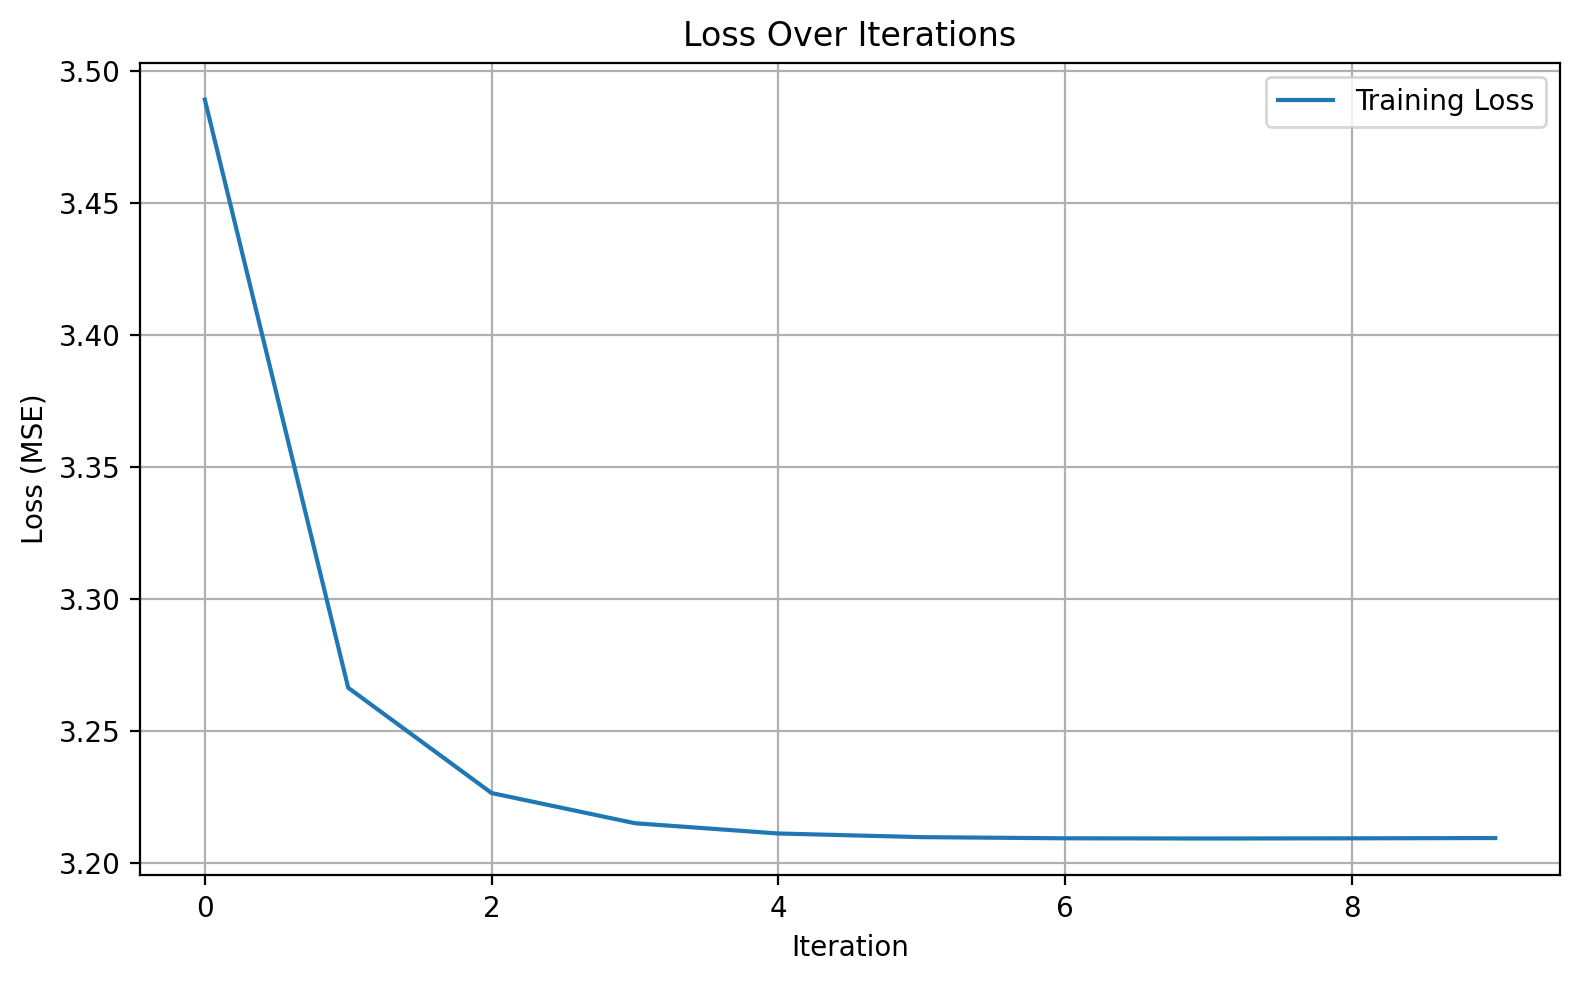

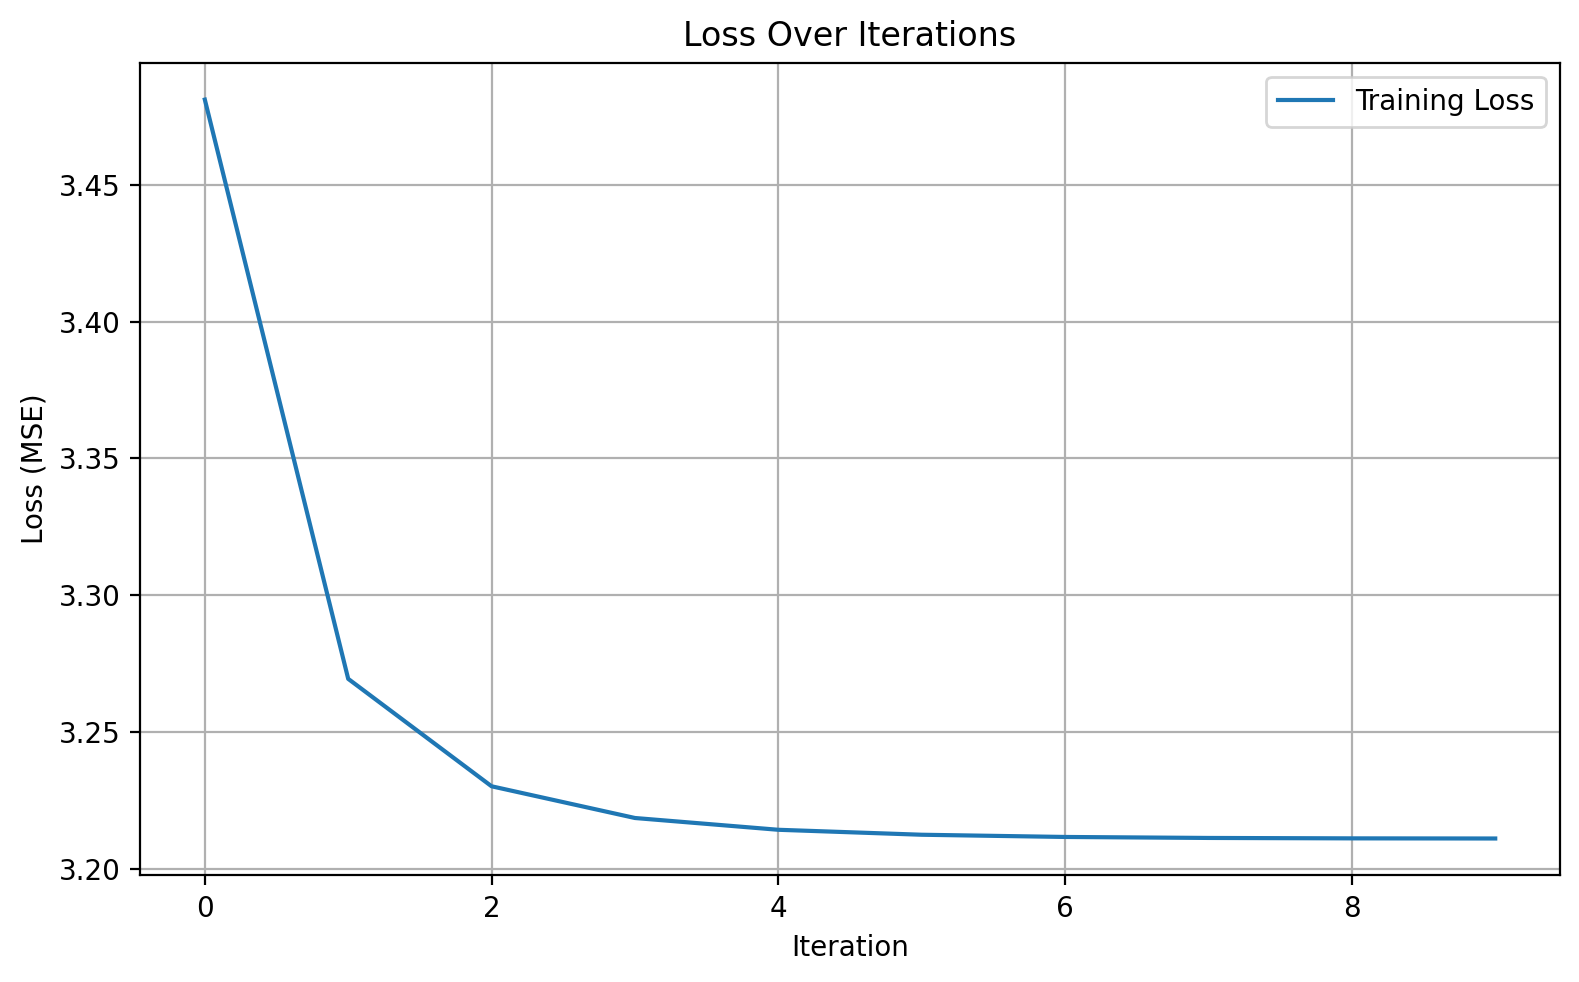

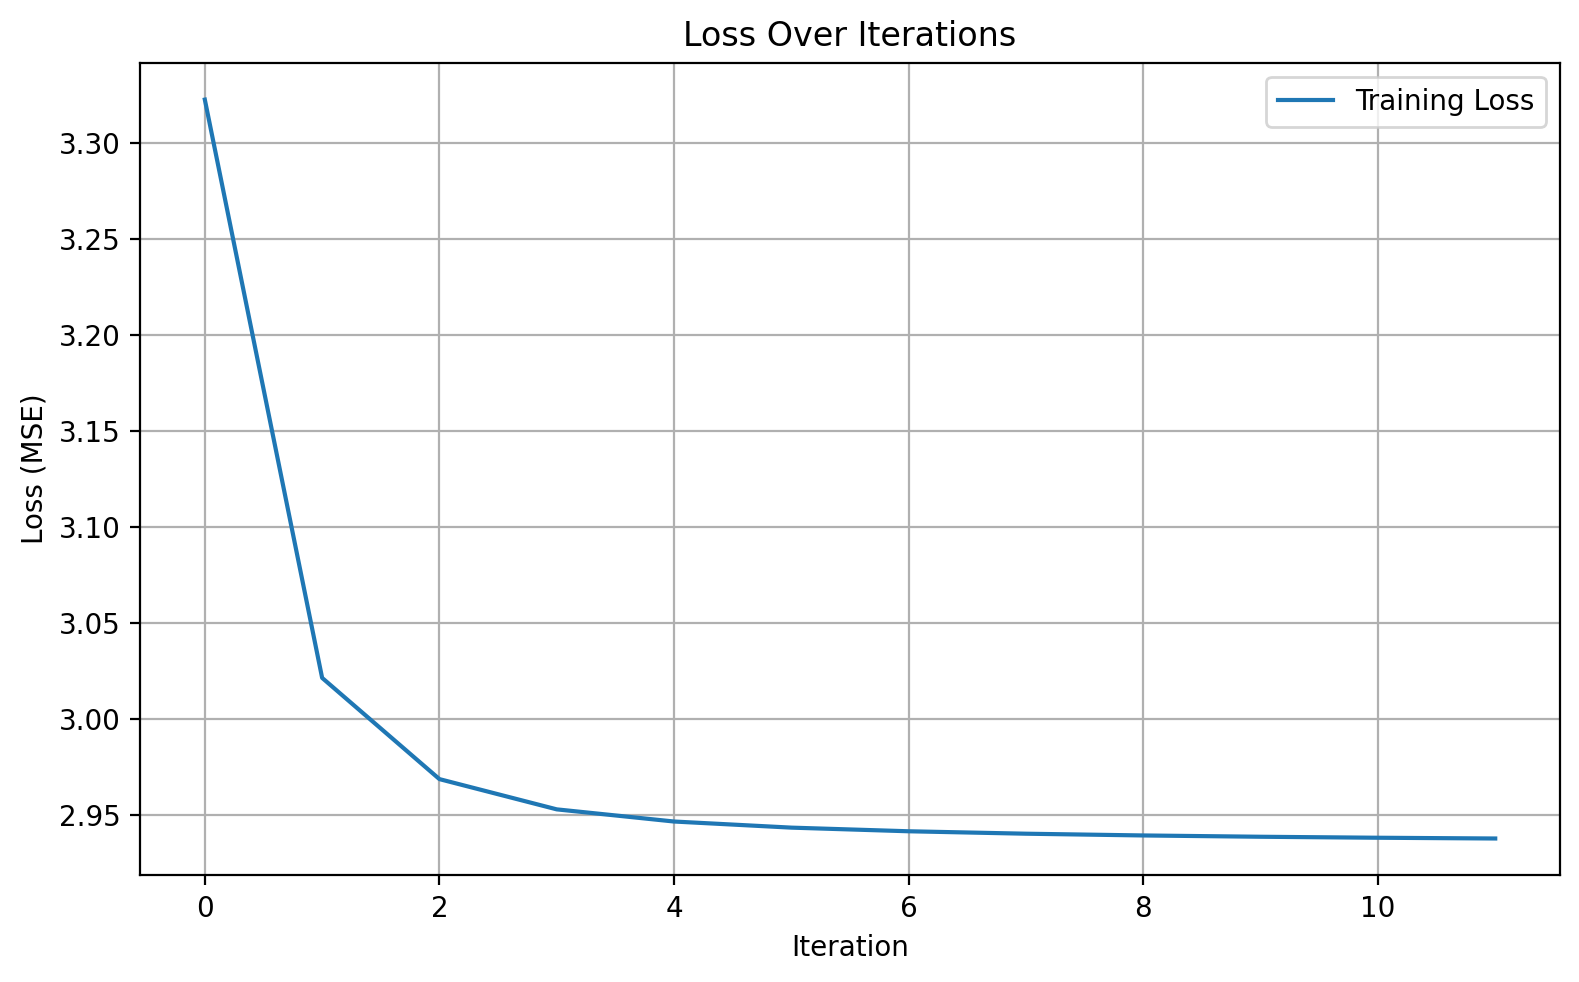

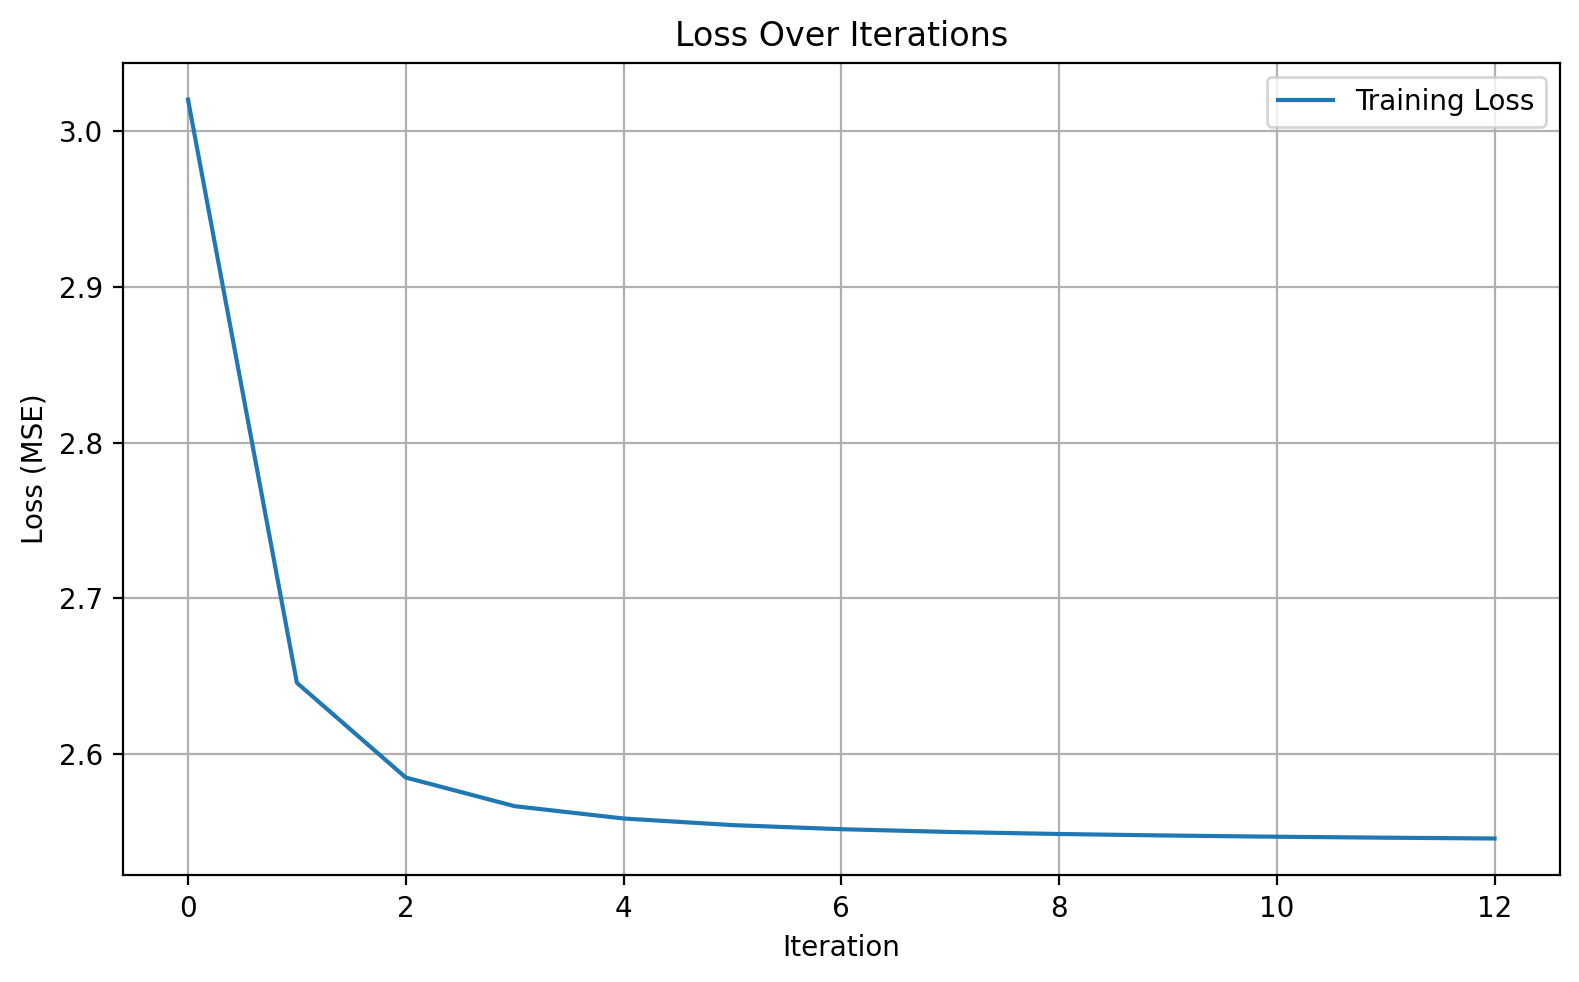

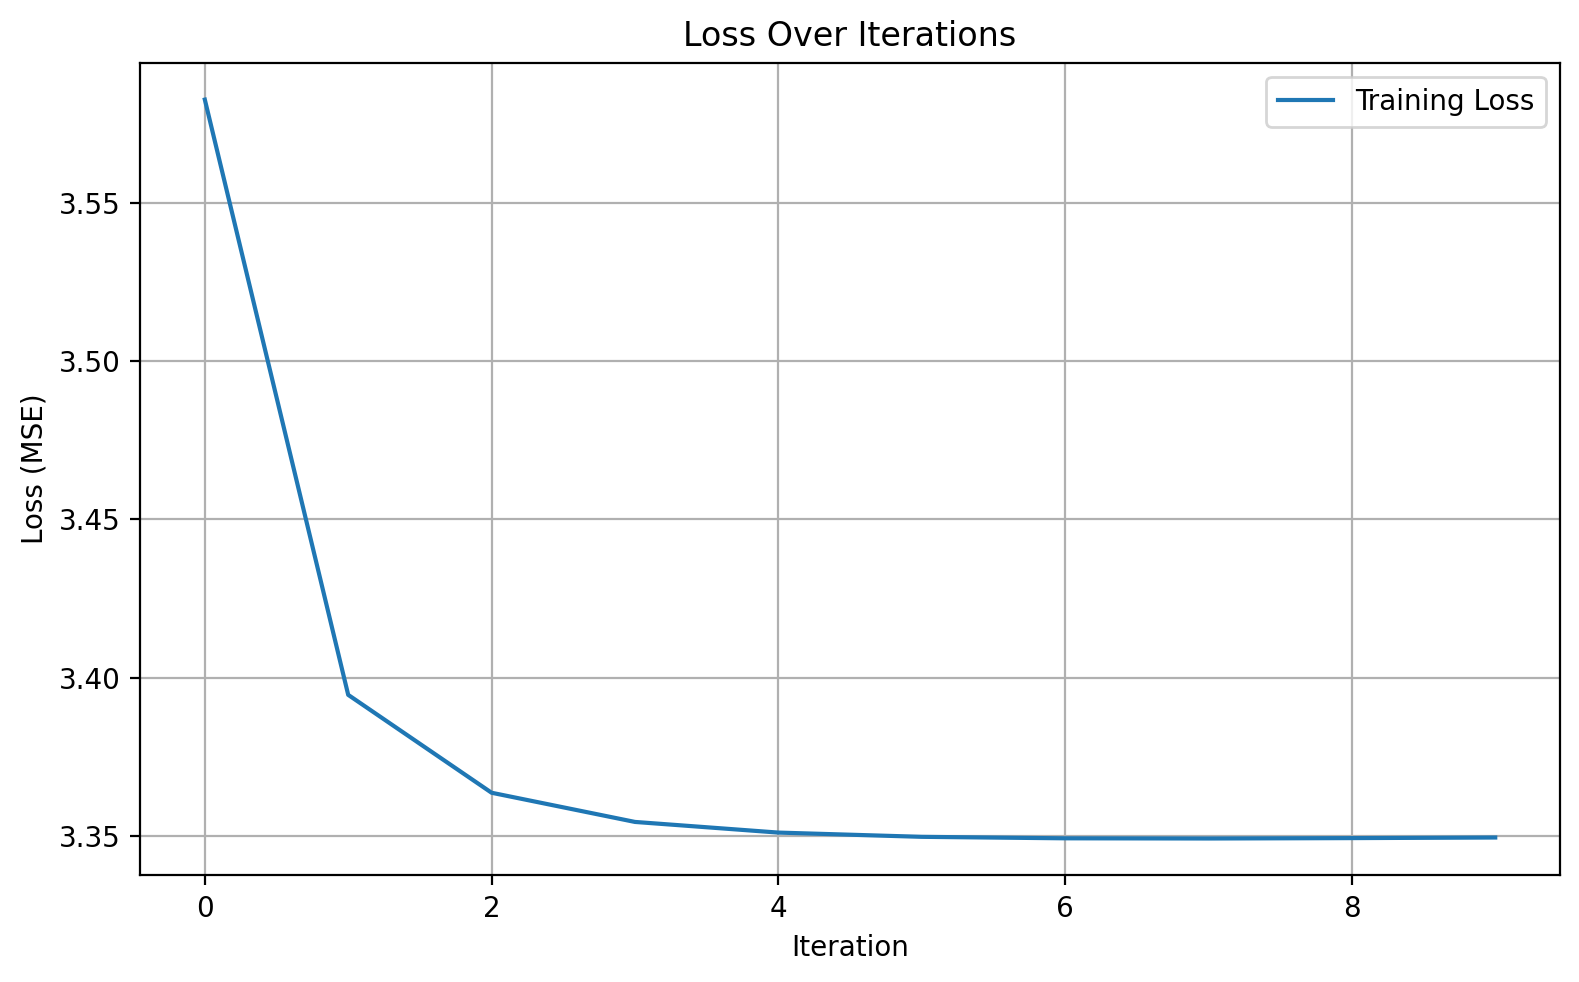

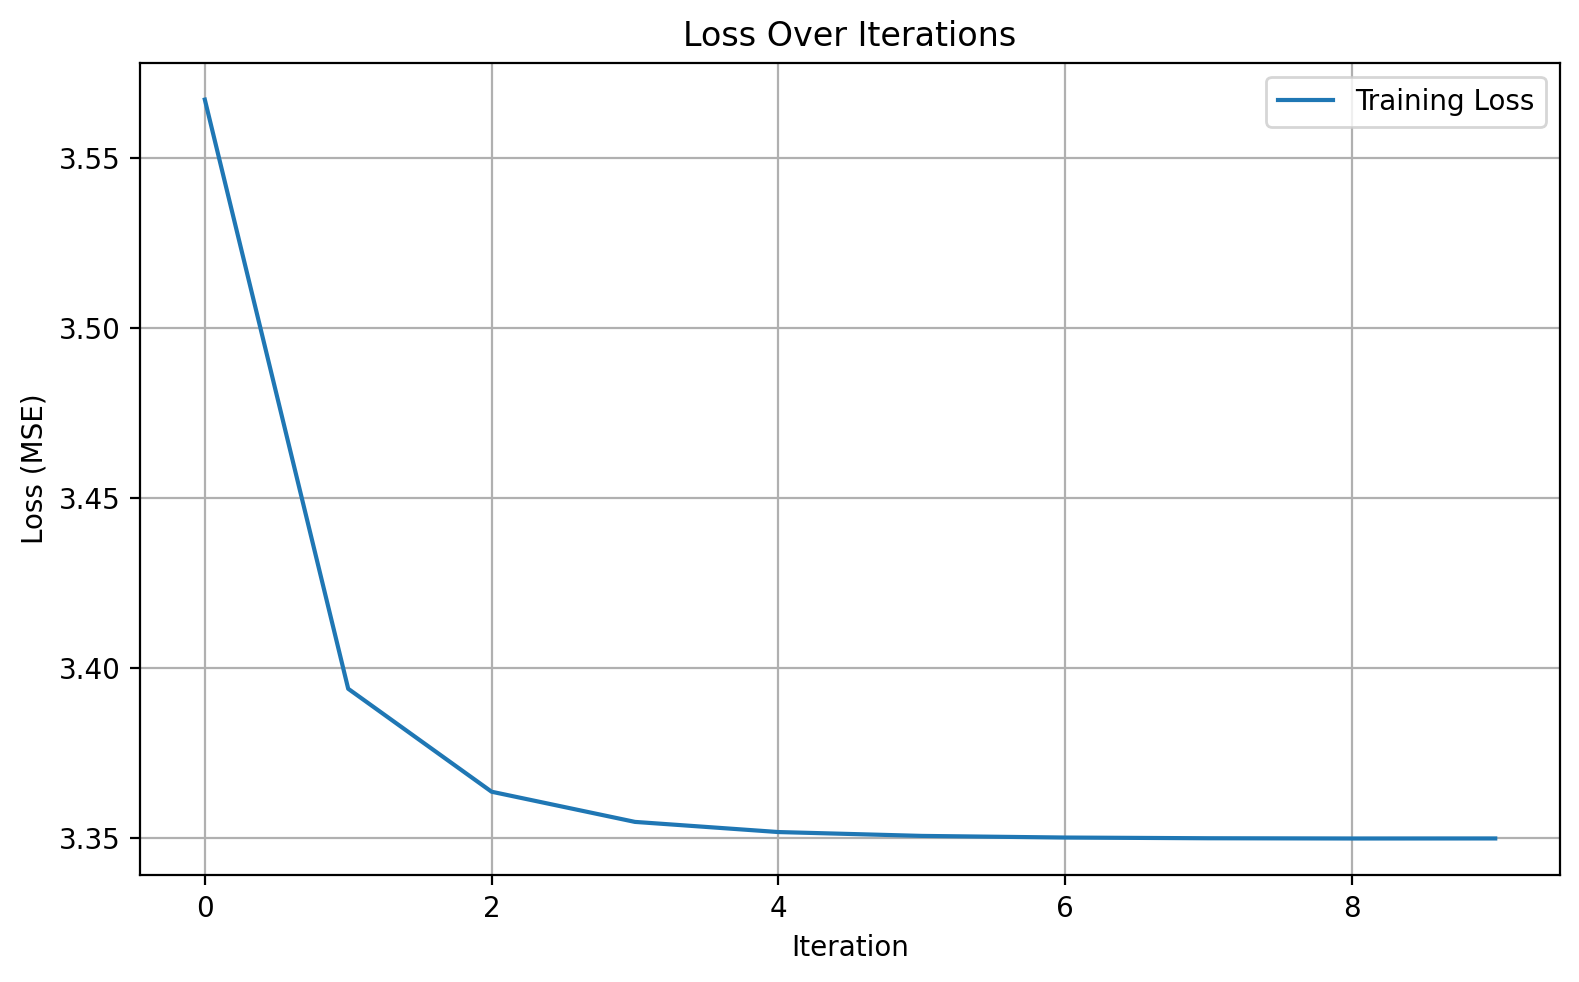

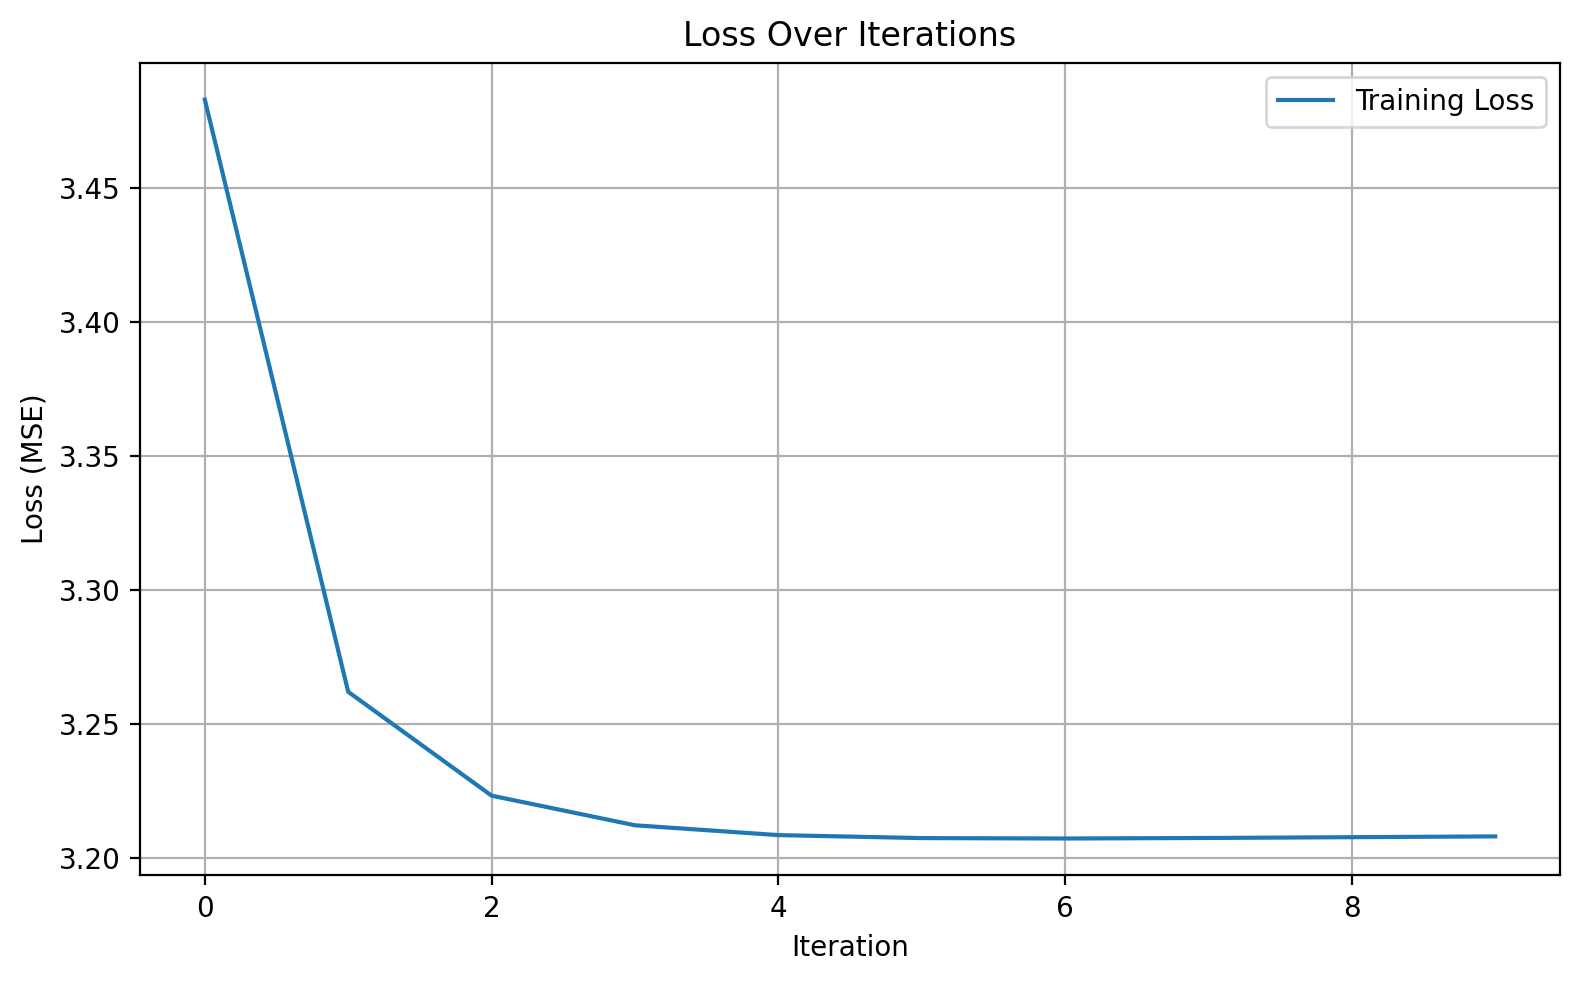

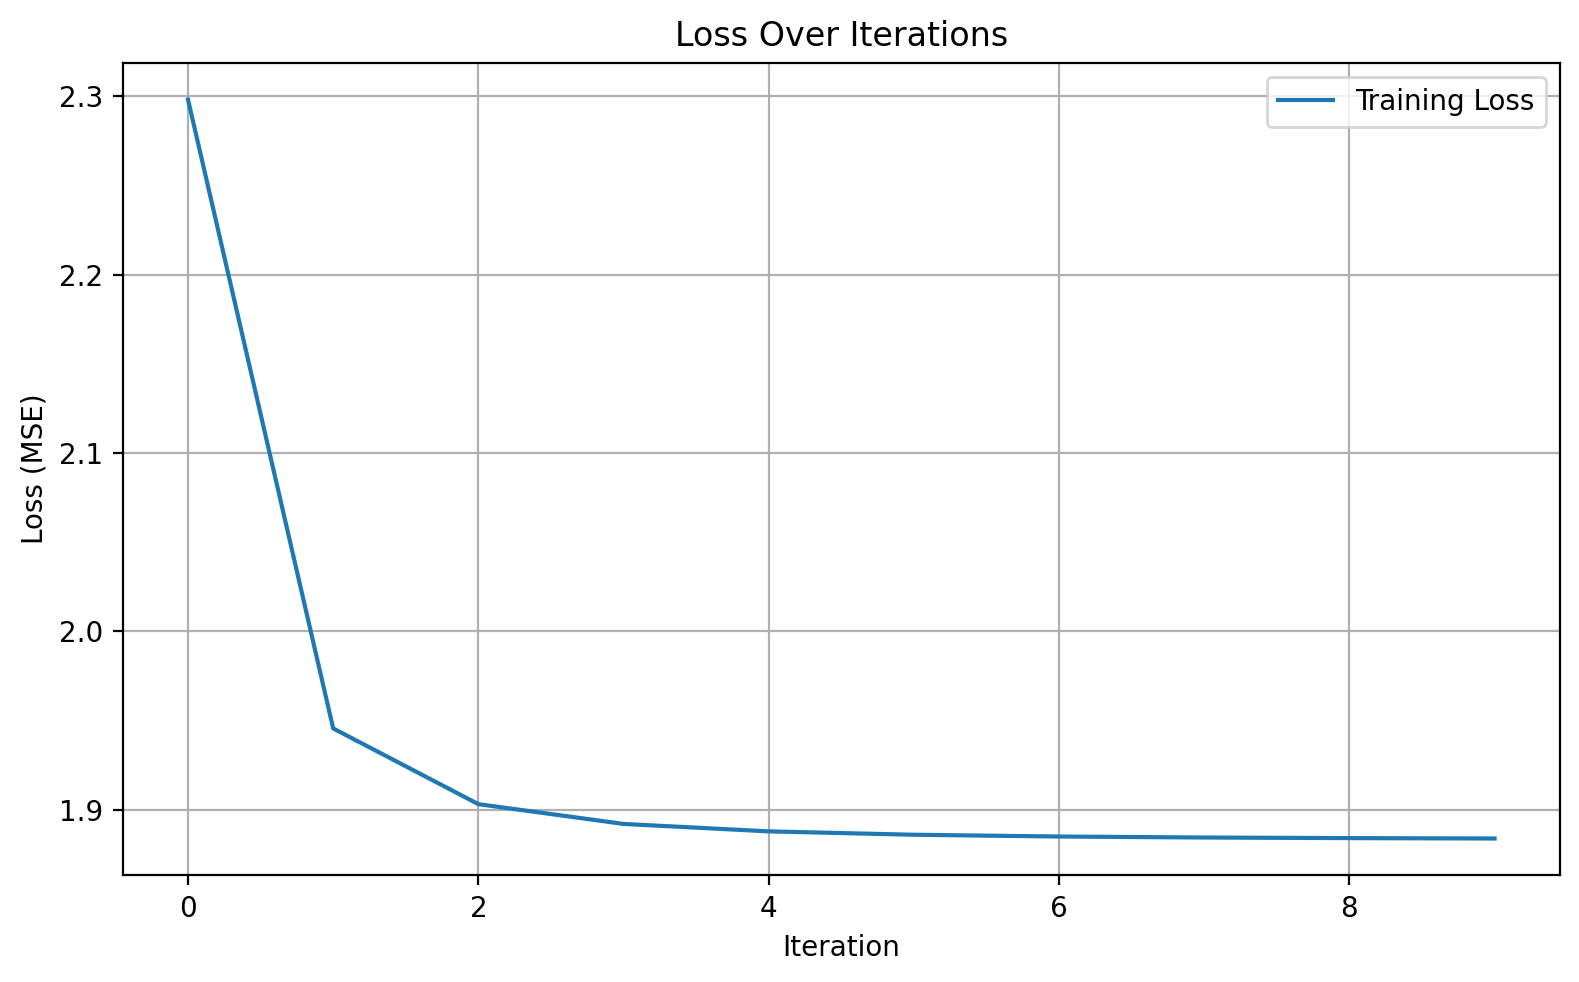

In [8]:
als_cf_model = CollaborativeFilteringALS()
for param in [
    {"num_feature": 50, "lambda": 1, "scale": 0.1, "normalization": False, "reg": True},
    {"num_feature": 50, "lambda": 1, "scale": 0.1, "normalization": True, "reg": True},
    {"num_feature": 50, "lambda": 1, "scale": 0.2, "normalization": True, "reg": True},
    {"num_feature": 100, "lambda": 1, "scale": 0.3, "normalization": True, "reg": True},
    {"num_feature": 200, "lambda": 1, "scale": 0.3, "normalization": True, "reg": True},
    {"num_feature": 30, "lambda": 0.1, "scale": 0.2, "normalization": True, "reg": True},
    # No reg
    {"num_feature": 30, "lambda": 0.0, "scale": 0.2, "normalization": True, "reg": True},
    {"num_feature": 50, "lambda": 0.0, "scale": 0.5, "normalization": True, "reg": True},
    {"num_feature": 500, "lambda": 0.0, "scale": 0.5, "normalization": True, "reg": True},
]:
    print(f"Starting training with params: {param}")
    
    als_cf_model.fit(
        data_preprocessed,
        iterations=100,
        num_features=param["num_feature"],
        lambda1_=param["lambda"],
        lambda2_=param["lambda"],
        scale=param["scale"],
        normalization=param["normalization"],
        reg=param["reg"]
    )

    # Format save directory and image filename
    save_suffix = f"scale{param['scale']}_features{param['num_feature']}_lambda{param['lambda']}_reg{param['reg']}_norm{param['normalization']}"
    save_path = f"../../save/collaborative_als/{save_suffix}"
    img_path = f"images/ALS/ALS_{save_suffix}.png"

    als_cf_model.save(save_path)
    als_cf_model.plot_loss(save=True, show=False, path=img_path)

In [7]:
import os
from IPython.display import display, HTML
from pathlib import Path

plot_folder = Path("./images/ALS")
plot_files = sorted([f for f in plot_folder.glob("ALS_*.png")])

html_blocks = []
row = []

for i, plot in enumerate(plot_files):
    caption = plot.stem.replace("_", ", ").replace("ALS", "ALS:")
    block = f"""
    <figure style="text-align: center; width: 30%;">
        <img src="{plot.as_posix()}" style="width: 100%; height: auto;" />
        <figcaption>{caption}</figcaption>
    </figure>
    """
    row.append(block)

    # Group in rows of 3
    if (i + 1) % 3 == 0 or i == len(plot_files) - 1:
        row_html = f"""
        <div style="display: flex; justify-content: center; gap: 20px; flex-wrap: wrap;">
            {''.join(row)}
        </div>
        <br/>
        """
        html_blocks.append(row_html)
        row = []

display(HTML("".join(html_blocks)))

#### Best Model

In [6]:
best_als_cf_model = CollaborativeFilteringALS()
best_als_cf_model.load("../../save/collaborative_als/scale0.1_features50_lambda1_regTrue_normTrue.npz")

2025-05-15 10:29:25,733 - [INFO] {src.models.base} - Model loaded from ../../save/collaborative_als/scale0.1_features50_lambda1_regTrue_normTrue.npz


In [7]:
recommendations = best_als_cf_model.predict(user_ids=[14], top_n=10)
print(recommendations)

predict took 0.0044 seconds
{14: [8305, 6309, 3400, 7077, 5510, 10017, 5434, 1894, 8340, 8743]}


In [8]:
marks = best_als_cf_model.get_marks(user_ids=[14])
print(marks[14])

[1.07768944 1.07412718 1.07892223 ... 1.07749901 1.07737605 1.07754923]


In [9]:
print(marks[14][103]) # watch ratio is 0.429126
print(marks[14][109]) # watch ratio is 1.482039
print(marks[14][120]) # watch ratio is 0.728738
print(marks[14][122]) # watch ratio is 1.150245

1.0650687111937436
1.08074362884514
1.0878645818807908
1.0781482462454193


### Evaluation

In [20]:
K = 100
N_USERS = float('+inf')

#### Sampling recommendations and ground truth

In [21]:
# testing on some users
recommendations = best_als_cf_model.predict(user_ids=[14, 19, 21, 23], top_n=K)
for user, rec in recommendations.items():
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(rec)))} / {K} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(rec)))} / {K} test recommendations in ground truth")

user 14: 100 / 100 train recommendations in ground truth
user 14: 56 / 100 test recommendations in ground truth
user 19: 100 / 100 train recommendations in ground truth
user 19: 37 / 100 test recommendations in ground truth
user 21: 100 / 100 train recommendations in ground truth
user 21: 42 / 100 test recommendations in ground truth
user 23: 100 / 100 train recommendations in ground truth
user 23: 93 / 100 test recommendations in ground truth


In [23]:
train_sample_user_ids = random.sample(list(data_preprocessed.index), min(N_USERS, len(data_preprocessed)))
train_sample_recommendations = {}
#print(f"Selected users: {train_sample_user_ids}")
train_sample_recommendations = best_als_cf_model.predict(user_ids=train_sample_user_ids, top_n=K)
train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = random.sample(list(test_data_preprocessed.index), min(N_USERS, len(test_data_preprocessed)))
test_sample_recommendations = {}
#print(f"Selected users: {test_sample_user_ids}")
test_sample_recommendations = best_als_cf_model.predict(user_ids=test_sample_user_ids, top_n=K)
test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

#### Bench Model (MAP@K, MAR@K, F1@K, NDCG@K)

In [25]:
from metrics import bench_model

print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K)

Training: k=100, users=inf

NDCG@100 = 99.5064%
MAP@100 = 99.4625%
MAR@100 = 0.9290%
F1@100 = 1.8408%
Testing: k=100, users=inf

NDCG@100 = 42.8016%
MAP@100 = 45.9036%
MAR@100 = 1.3895%
F1@100 = 2.6973%


#### Novelty

In [ ]:
novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")

### Conclusion

The Ridge ALS model is fast to train and performs well on the training data, achieving high NDCG@100 and MAP@100 scores, similar to the baseline. 

However, the testing performance shows the same limitations: a noticeable drop in ranking metrics and very low recall.

| Type    | k   | Users | NDCG@100   | MAP@100   | MAR@100   | F1@100    |
|----------|-----|--------|------------|-----------|-----------|-----------|
| Training | 100 | All     | 0.995064   | 0.994625  | 0.009290  | 0.018408  |
| Testing  | 100 | All     | 0.428016   | 0.459036  | 0.013895  | 0.026973  |

While regularization in Ridge ALS helps reduce overfitting compared to the baseline, the model still struggles with missing interactions which reflects a drop in the meaningful metrics such as NDCG and MAP in test set.

To better handle the sparsity and implicit nature of video watch data, we should consider implicit feedback methods such as implicit matrix factorization. These models are specifically designed to treat missing entries not as zeros but as unknowns. This should lead to more robust generalization.

---

## Matrix Factorization with implicit ALS - Collaborative Filtering

The previous model struggles handling missing ratings. Another approach is using implicit ALS that is adapted for larg sparse matrix. 

This is the Matrix Factorization approach using implicit ALS algorithm and Ridge regularization - See [paper](https://www.academia.edu/download/37108248/2010_-_I._Pilaszy__D._Zibriczky__D._Tikk_-_ALS1.pdf)

There is some implementation [online](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe) as well (I find it dirty, I am not using it :) )

I changed the formula a little bit to adapt our case. We are not hanlding binary notation but rather a range between $0$ and $+\infty$

**Assumption**: Same as Ridge ALS

**Predictions**: No changes -> $ Y = (U^T V) $

**Cost Function**:

$$ E_{IALS}(U, V) = || C \cdot (\hat{Y} - U^TV) ||^2 + \lambda || U ||^2 + \lambda || V ||^2 $$

$C$ now is a weighted matrix. It gives more value on some specifc ratings (the 16% in our sparse training matrix)

Lambdas are the same, does not matter to be honest

**Learning**:

$$ V = (UCU^T + \lambda_1 I)^{-1} U (C * \hat{Y}) $$

$$ U = (VCV^T + \lambda_2 I)^{-1} V (C * \hat{Y})^T $$

wrapper implication of the `implicit` library can be found `src/models/collaborative_implicit_als.py`

### Model & Hyperparam Tuning

In [9]:
os.makedirs("../../save/collaborative_ials", exist_ok=True)
ials_cf_model = CollaborativeFilteringImplicitALS()
for param in [
    {"num_feature": 30, "lambda": 1, "alpha": 15}, # +0.05
    {"num_feature": 50, "lambda": 1, "alpha": 15}, # +0.05
    {"num_feature": 50, "lambda": 1, "alpha": 30}, # 0.046
    {"num_feature": 100,  "lambda": 1, "alpha": 15}, # +0.05
    {"num_feature": 100,  "lambda": 1, "alpha": 30}, # +0.0405
    {"num_feature": 100,  "lambda": 1, "alpha": 50}, # 0.03
    {"num_feature": 100,  "lambda": 1, "alpha": 75},
    {"num_feature": 100,  "lambda": 10, "alpha": 50}, # 0.034
    {"num_feature": 30,  "lambda": 0.1, "alpha": 15}, # 0.06
    {"num_feature": 100,  "lambda": 0.1, "alpha": 15}, # 0.05
    # more than 0.06
    {"num_feature": 30, "lambda": 0.0, "alpha": 15}, # 0.0
    {"num_feature": 50, "lambda": 0.0, "alpha": 30},
    {"num_feature": 100, "lambda": 0.0, "alpha": 30},
]:
    print(f"Strating training with params: {param}")
    ials_cf_model.fit(
        data_preprocessed,
        iterations=25,
        num_features=param["num_feature"],
        alpha=param["alpha"],
        lambda_=param["lambda"],
        random_state=42,
    )
    save_path = f"../../save/collaborative_ials/ials_nf{param['num_feature']}_l{param['lambda']}_a{param['alpha']}"
    ials_cf_model.save(save_path)

Strating training with params: {'num_feature': 30, 'lambda': 1, 'alpha': 15}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 35.8802 seconds


2025-05-15 09:58:53,735 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf30_l1_a15.pkl


Strating training with params: {'num_feature': 50, 'lambda': 1, 'alpha': 15}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 34.3905 seconds


2025-05-15 09:59:28,656 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf50_l1_a15.pkl


Strating training with params: {'num_feature': 50, 'lambda': 1, 'alpha': 30}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 37.0403 seconds


2025-05-15 10:00:06,273 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf50_l1_a30.pkl


Strating training with params: {'num_feature': 100, 'lambda': 1, 'alpha': 15}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 30.7506 seconds


2025-05-15 10:00:37,861 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l1_a15.pkl


Strating training with params: {'num_feature': 100, 'lambda': 1, 'alpha': 30}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 32.9309 seconds


2025-05-15 10:01:13,509 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l1_a30.pkl


Strating training with params: {'num_feature': 100, 'lambda': 1, 'alpha': 50}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 43.8473 seconds


2025-05-15 10:01:57,917 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l1_a50.pkl


Strating training with params: {'num_feature': 100, 'lambda': 1, 'alpha': 75}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 31.3951 seconds


2025-05-15 10:02:29,869 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l1_a75.pkl


Strating training with params: {'num_feature': 100, 'lambda': 10, 'alpha': 50}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 31.7823 seconds


2025-05-15 10:03:02,193 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l10_a50.pkl


Strating training with params: {'num_feature': 30, 'lambda': 0.1, 'alpha': 15}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 37.7388 seconds


2025-05-15 10:03:41,001 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf30_l0.1_a15.pkl


Strating training with params: {'num_feature': 100, 'lambda': 0.1, 'alpha': 15}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 33.1818 seconds


2025-05-15 10:04:14,826 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l0.1_a15.pkl


Strating training with params: {'num_feature': 30, 'lambda': 0.0, 'alpha': 15}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 41.5013 seconds


2025-05-15 10:04:56,831 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf30_l0.0_a15.pkl


Strating training with params: {'num_feature': 50, 'lambda': 0.0, 'alpha': 30}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 35.1600 seconds


2025-05-15 10:05:32,528 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf50_l0.0_a30.pkl


Strating training with params: {'num_feature': 100, 'lambda': 0.0, 'alpha': 30}


  0%|          | 0/25 [00:00<?, ?it/s]

fit took 31.3784 seconds


2025-05-15 10:06:04,583 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ials/ials_nf100_l0.0_a30.pkl


### Selecting Best Model

In [4]:
best_ials_cf_model = CollaborativeFilteringImplicitALS()
best_ials_cf_model.load("../../save/collaborative_ials/ials_nf100_l1_a75")

2025-05-15 10:39:38,250 - [INFO] {src.models.base} - Model loaded from ../../save/collaborative_ials/ials_nf100_l1_a75


In [5]:
recommendations = best_ials_cf_model.predict(user_ids=[14], top_n=10)
print(recommendations)

predict took 0.1501 seconds
{14: [2047, 2646, 5841, 184, 1920, 4150, 1754, 206, 972, 6642]}


In [9]:
marks = best_ials_cf_model.get_marks(user_ids=[14])
print(marks[14][103]) # watch ratio is 0.429126
print(marks[14][109]) # watch ratio is 1.482039
print(marks[14][120]) # watch ratio is 0.728738
print(marks[14][122]) # watch ratio is 1.150245

-0.01502014696598053
0.14642146229743958
-0.0011387094855308533
-0.1705707460641861


### Evaluation

In [11]:
K = 100
N_USERS = 500 #float('+inf')

#### Sampling recommendations and ground truth

In [12]:
# testing on some users
recommendations = best_ials_cf_model.predict(user_ids=[14, 19, 21, 23], top_n=K)
for user, rec in recommendations.items():
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(rec)))} / {K} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(rec)))} / {K} test recommendations in ground truth")

predict took 0.0819 seconds
user 14: 0 / 100 train recommendations in ground truth
user 14: 0 / 100 test recommendations in ground truth
user 19: 0 / 100 train recommendations in ground truth
user 19: 0 / 100 test recommendations in ground truth
user 21: 0 / 100 train recommendations in ground truth
user 21: 0 / 100 test recommendations in ground truth
user 23: 0 / 100 train recommendations in ground truth
user 23: 0 / 100 test recommendations in ground truth


In [ ]:
train_sample_user_ids = list(data_preprocessed.index) if N_USERS > len(data_preprocessed) else random.sample(list(data_preprocessed.index), N_USERS)
train_sample_recommendations = best_ials_cf_model.predict(user_ids=train_sample_user_ids, top_n=K)
train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = list(data_preprocessed.index) if N_USERS > len(test_data_preprocessed) else random.sample(list(test_data_preprocessed.index), N_USERS)
test_sample_recommendations = best_ials_cf_model.predict(user_ids=test_sample_user_ids, top_n=K)
test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

#### Bench Model (NDCG@K, MAP@K, MAR@K, F1@K)

In [ ]:
from metrics import bench_model

print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K)

#### Novelty

In [ ]:
from metrics import novelty

novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")

### Conclusion

The model achieves excellent performance on the training set, with NDCG and MAP values close to 1.0. This shows that implicit ALS is effective at capturing observed interactions and filling in missing values.

On the test set, the results are more realistic, with NDCG and MAP around 0.32 indicating the model is starting to generalize but still has room for improvement.

However, the Mean Average Recall (MAR) remains very low in both training and testing, which means the model retrieves only a small portion of all relevant items. As a result, the F1 score is also low. This highlights a key limitation: while the top predictions may be accurate, the model lacks coverage. Improving recall should be a priority in future work.

| Phase    | k   | Users | NDCG@100 | MAP@100 | MAR@100 | F1@100 |
|----------|-----|--------|----------|---------|---------|--------|
| Training | 100 | 500    | 0.997605 | 0.997560 | 0.009321 | 0.018470 |
| Testing  | 100 | 500    | 0.322882 | 0.322220 | 0.009748 | 0.018923 |


## Neural Collaborative Filtering (NCF)

This is the generalization of the Matrix Factorization approach (MF) - See [paper](https://dl.acm.org/doi/abs/10.1145/3038912.3052569)

NCF approach tries to solve two problems:
1. Simple inner product cannot estimate complex user-item relation
2. Augmenting K factors solve the previous issue but leads to overfitting

<center><img src="images/NCF.png"/></center>

This collaborative filtering model uses a gradient descent approach with pointwise loss.

For simplicity, we use a single layer

**Predictions**:

$$ Y = U @ V + b$$
- U is a learned matrix representing user embeddings.
- V is a learned matrix of representing item embeddings.
- b is a learnable bias vector.

The goal is to learn U, I and b by minimizing the MSE between predicted watch ratio and known watch ratios.

**Cost Function:**

$$ J_{U,V,b}(Y) = \frac{1}{2} || R * (U @ V + b − Y) ||^{2} + \lambda || U ||^{2} + \lambda || V ||^{2} $$

- Y is the normalized user-item rating matrix (only nonzero entries are considered).
- λ is the regularization parameter.
- Only U, I and b are updated during training.

### Model & Hyperparam Tuning

In [7]:
os.makedirs("../../save/collaborative_ncf", exist_ok=True)

ncf_params_list = [
    {"num_feature": 30, "lambda": 1, "reg": False},
    {"num_feature": 50, "lambda": 1, "reg": False},
    {"num_feature": 50, "lambda": 1, "reg": True},
    {"num_feature": 100, "lambda": 1, "reg": True},
    {"num_feature": 100, "lambda": 10, "reg": True},
    {"num_feature": 30, "lambda": 0.1, "reg": True},
    {"num_feature": 100, "lambda": 0.1, "reg": True},
    {"num_feature": 30, "lambda": 0.0, "reg": False},
    {"num_feature": 50, "lambda": 0.0, "reg": False},
    {"num_feature": 100, "lambda": 0.0, "reg": False},
]

for param in ncf_params_list:
    print(f"Starting training with params: {param}")

    ncf_model = CollaborativeFilteringNCF()
    ncf_model.fit(
        data=data_preprocessed.fillna(0),
        iterations=50,
        learning_rate=1e-1,
        num_features=param["num_feature"],
        lambda_=param["lambda"],
        reg=param["reg"],
        min_mse=1e-3
    )
    save_path = f"../../save/collaborative_ncf/ncf_nf{param['num_feature']}_l{param['lambda']}_r{int(param['reg'])}.npz"
    ncf_model.save(save_path)

Starting training with params: {'num_feature': 30, 'lambda': 1, 'reg': False}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:48:20,326 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf30_l1_r0.npz


fit took 47.0584 seconds
Starting training with params: {'num_feature': 50, 'lambda': 1, 'reg': False}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:49:08,606 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf50_l1_r0.npz


fit took 47.9424 seconds
Starting training with params: {'num_feature': 50, 'lambda': 1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:49:57,931 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf50_l1_r1.npz


fit took 48.9995 seconds
Starting training with params: {'num_feature': 100, 'lambda': 1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:50:50,941 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l1_r1.npz


fit took 52.6146 seconds
Starting training with params: {'num_feature': 100, 'lambda': 1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:51:45,576 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l1_r1.npz


fit took 54.2925 seconds
Starting training with params: {'num_feature': 100, 'lambda': 1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:52:39,868 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l1_r1.npz


fit took 53.9534 seconds
Starting training with params: {'num_feature': 100, 'lambda': 1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:53:35,830 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l1_r1.npz


fit took 55.5542 seconds
Starting training with params: {'num_feature': 100, 'lambda': 10, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:54:31,240 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l10_r1.npz


fit took 54.9630 seconds
Starting training with params: {'num_feature': 30, 'lambda': 0.1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:55:22,618 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf30_l0.1_r1.npz


fit took 51.0346 seconds
Starting training with params: {'num_feature': 100, 'lambda': 0.1, 'reg': True}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:56:19,615 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l0.1_r1.npz


fit took 56.6143 seconds
Starting training with params: {'num_feature': 30, 'lambda': 0.0, 'reg': False}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:57:10,751 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf30_l0.0_r0.npz


fit took 50.7836 seconds
Starting training with params: {'num_feature': 50, 'lambda': 0.0, 'reg': False}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:58:02,817 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf50_l0.0_r0.npz


fit took 51.7055 seconds
Starting training with params: {'num_feature': 100, 'lambda': 0.0, 'reg': False}


Training NCF:   0%|          | 0/50 [00:00<?, ?it/s]

2025-05-15 18:58:58,620 - [INFO] {src.models.base} - Model saved to ../../save/collaborative_ncf/ncf_nf100_l0.0_r0.npz


fit took 55.4442 seconds


In [27]:
best_ncf_model = CollaborativeFilteringNCF()
best_ncf_model.load("../../save/collaborative_ncf/ncf_nf100_l10_r1.npz")

2025-05-15 19:32:55,983 - [INFO] {src.models.base} - Model loaded from ../../save/collaborative_ncf/ncf_nf100_l10_r1.npz


In [28]:
recommendations = ncf_model.predict(user_ids=[14], top_n=10)
print(recommendations)

predict took 0.5395 seconds
{14: [7445, 4362, 7456, 3073, 5901, 2896, 7379, 7259, 8424, 525]}


In [38]:
marks = ncf_model.get_marks(user_ids=[14])
print(marks[14])

[1.3100871 0.7988808 2.9097705 ... 0.7315328 2.9136558 1.9420174]


In [30]:
print(marks[14][103]) # watch ratio is 0.429126
print(marks[14][109]) # watch ratio is 1.482039
print(marks[14][120]) # watch ratio is 0.728738
print(marks[14][122]) # watch ratio is 1.150245

0.5234215
1.7868838
1.676322
1.2512525


### Evaluation

In [31]:
K = 10
N_USERS = 40

#### Sampling recommendations and ground truth

In [32]:
# testing on some users
top_n = 100
recommendations = ncf_model.predict(user_ids=[14, 19, 21, 23], top_n=top_n)
for user, rec in recommendations.items():
    print(f"user {user}: {len(set(train_ground_truth[user]).intersection(set(rec)))} / {top_n} train recommendations in ground truth")
    print(f"user {user}: {len(set(test_ground_truth[user]).intersection(set(rec)))} / {top_n} test recommendations in ground truth")

predict took 0.5037 seconds
user 14: 0 / 100 train recommendations in ground truth
user 14: 0 / 100 test recommendations in ground truth
user 19: 0 / 100 train recommendations in ground truth
user 19: 0 / 100 test recommendations in ground truth
user 21: 0 / 100 train recommendations in ground truth
user 21: 0 / 100 test recommendations in ground truth
user 23: 0 / 100 train recommendations in ground truth
user 23: 0 / 100 test recommendations in ground truth


In [33]:
train_sample_user_ids = random.sample(list(data_preprocessed.index), min(N_USERS, len(data_preprocessed)))
train_sample_recommendations = {}
print(f"Selected users: {train_sample_user_ids}")
train_sample_recommendations = ncf_model.predict(user_ids=train_sample_user_ids, top_n=K)
train_sample_ground_truth = {user: train_ground_truth.get(user, []) for user in train_sample_user_ids}

###################

test_sample_user_ids = random.sample(list(test_data_preprocessed.index), min(N_USERS, len(test_data_preprocessed)))
test_sample_recommendations = {}
print(f"Selected users: {test_sample_user_ids}")
test_sample_recommendations = ncf_model.predict(user_ids=test_sample_user_ids, top_n=K)
test_sample_ground_truth = {user: test_ground_truth.get(user, []) for user in test_sample_user_ids}

Selected users: [4183, 1578, 1066, 6036, 6507, 2552, 2061, 5608, 2436, 6479, 3014, 6838, 60, 4073, 5486, 4227, 144, 1415, 5536, 3821, 4127, 233, 2797, 1674, 6993, 5434, 6162, 6443, 2791, 7124, 4185, 2137, 6368, 733, 1857, 3990, 1745, 5871, 5762, 4624]
predict took 0.5757 seconds
Selected users: [937, 464, 1404, 622, 1105, 355, 456, 1189, 1337, 327, 1166, 338, 1022, 1300, 281, 472, 586, 1247, 973, 991, 927, 773, 1030, 1160, 847, 885, 471, 780, 536, 9, 910, 1114, 1089, 975, 1303, 113, 1003, 497, 650, 1296]
predict took 0.6038 seconds


#### Bench Model (NDCG@K, MAP@K, MAR@K, F1@K)

In [36]:
print(f"Training: k={K}, users={N_USERS}\n")
bench_model(recommendations=train_sample_recommendations, ground_truth=train_sample_ground_truth, k=K*100)

print(f"Testing: k={K}, users={N_USERS}\n")
bench_model(recommendations=test_sample_recommendations, ground_truth=test_sample_ground_truth, k=K*100)

Training: k=10, users=40

NDCG@1000 = 0.0000
MAP@1000 = 0.0000
MAR@1000 = 0.0000
F1@1000 = 0.0000
Testing: k=10, users=40

NDCG@1000 = 0.0000
MAP@1000 = 0.0000
MAR@1000 = 0.0000
F1@1000 = 0.0000


#### Novelty

In [ ]:
novelty_score = novelty(train_sample_recommendations, item_popularity)
test_novelty_score = novelty(test_sample_recommendations, item_popularity)

print(f"Train Novelty: {novelty_score:.4f}")
print(f"Test Novelty: {test_novelty_score:.4f}")